In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from models.mnist_model import  MemoryAutoEncoder

## Dataset

In [2]:
def get_dataloaders(digit_class):
    """
    This will allow us to get a train dataset with only one digit class
    and a test loader with digits from all classes. Those digit from a class other than digit_class
    would be the anomalies.
    :param digit_class: The digit, i.e. 0-9
    :return: train and test loaders
    """
    single_class_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=False,
        transform=transforms.ToTensor()
    )
    idx = single_class_dataset.targets == digit_class
    single_class_dataset.data = single_class_dataset.data[idx]
    single_class_dataset.targets = single_class_dataset.targets[idx]

    train_loader = DataLoader(
        single_class_dataset,
        batch_size=64,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.MNIST(
            root='./data',
            train=False,
            download=False,
            transform=transforms.ToTensor()
        ),
        batch_size=64,
        shuffle=True
    )

    return train_loader, test_loader

In [3]:
ID_CLASS = 2
train, test = get_dataloaders(ID_CLASS)
print("Shape of train data: ", train.dataset.data.shape)
print("Shape of test data: ", test.dataset.data.shape)

print("There are {}% of samples from class {} in the test set".format(
    round(test.dataset.targets[test.dataset.targets == ID_CLASS].shape[0] / test.dataset.targets.shape[0] * 100, 2),
    ID_CLASS
))

Shape of train data:  torch.Size([5958, 28, 28])
Shape of test data:  torch.Size([10000, 28, 28])
There are 10.32% of samples from class 2 in the test set


In [4]:
model = MemoryAutoEncoder(n=100, c=256)
n_epochs = 100
lr = 1e-3
alpha = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse_criterion = torch.nn.MSELoss(reduction='mean')

def entropy_criterion(w):
    return torch.sum(-w * torch.log(w + 1e-12), dim=1).mean()

Train Epoch: 0 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.73
Train Epoch: 10 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.71
Train Epoch: 20 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.71
Train Epoch: 30 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.72
Train Epoch: 40 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.70
Train Epoch: 50 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.72
Train Epoch: 60 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.70
Train Epoch: 70 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.70
Train Epoch: 80 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.71
Train Epoch: 90 [0/5958 (0%)]	Loss MSE: 0.02	 Entropy Loss: 3.70


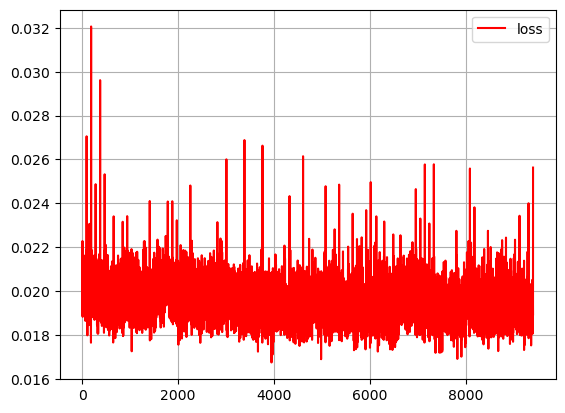

In [7]:
loss_record = {'loss': []}
for epoch in range(n_epochs):
    for batch_idx, (data, _) in enumerate(train):
        optimizer.zero_grad()
        output, w = model(data)
        #print(" max w", w.max())

        mse_loss = mse_criterion(output, data)
        entropy_loss = entropy_criterion(w)
        loss = mse_loss + alpha*entropy_loss
        loss.backward()
        optimizer.step()

        loss_record['loss'].append(loss.item())

        if batch_idx % 100 == 0 and epoch % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss MSE: {:.2f}\t Entropy Loss: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train.dataset),
                       100. * batch_idx / len(train), mse_loss.item(), entropy_loss.item()),

            )

# Plot loss
fig, ax = plt.subplots()
ax.plot(loss_record['loss'], label='loss', color='red')
plt.grid()
plt.legend(loc='best')
plt.show()

# Test reconstruction error

In [33]:
def plot_hist_of_recon_error(class_id):
    # Get all samples from class 1
    test_input = test.dataset.data[test.dataset.targets == class_id].unsqueeze(1).float()
    test_out, _ = model(test_input)

    # Reconstruction error of all the batch
    r_error = (torch.sqrt(torch.sum(test_input - test_out, dim=(1, 2, 3))**2)).detach().numpy()
    # Histogram of the reconstruction error
    plt.title("Histogram of the reconstruction error for class {}".format(class_id))
    plt.hist(r_error, bins=50, color='red', label='class {}'.format(class_id))
    plt.grid()

    # Hisrtogram of the reconstruction error for the class 2
    class_2_inputs = test.dataset.data[test.dataset.targets == 2].unsqueeze(1).float()
    class_2_out, _ = model(class_2_inputs)
    r_error_2 = (torch.sqrt(torch.sum(class_2_inputs - class_2_out, dim=(1, 2, 3))**2)).detach().numpy()
    plt.hist(r_error_2, bins=50, color='blue', label='class 2', alpha=0.7)

    plt.legend(loc='best')
    plt.show()

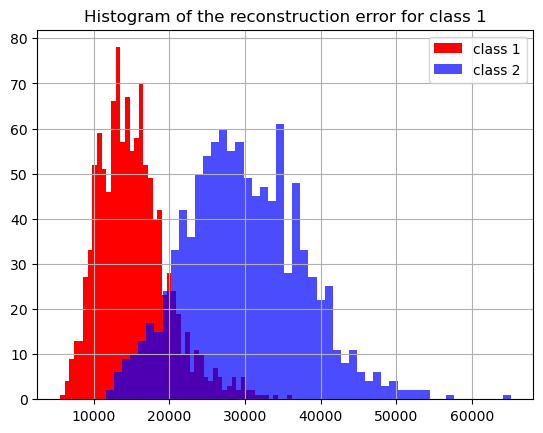

In [34]:
plot_hist_of_recon_error(1)

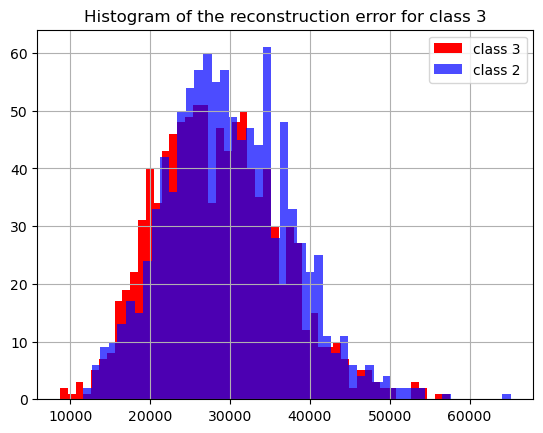

In [35]:
plot_hist_of_recon_error(3)

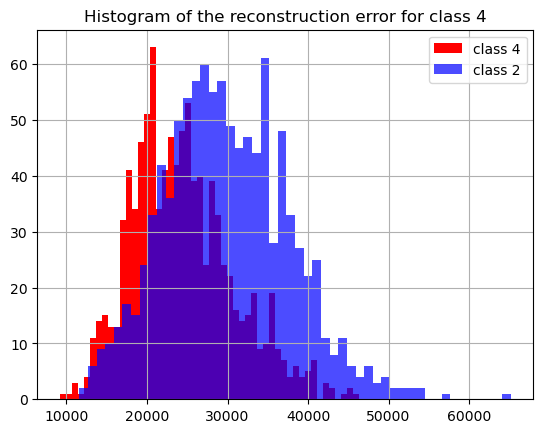

In [36]:
plot_hist_of_recon_error(4)

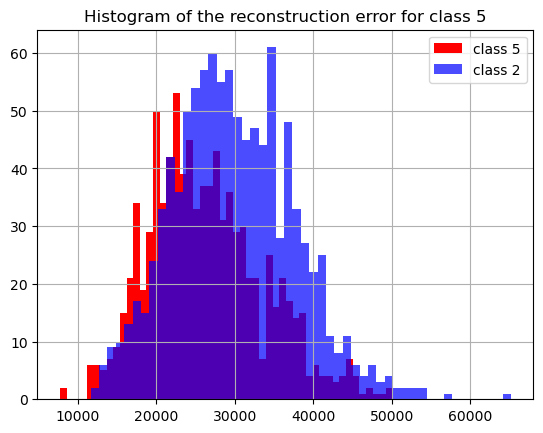

In [37]:
plot_hist_of_recon_error(5)

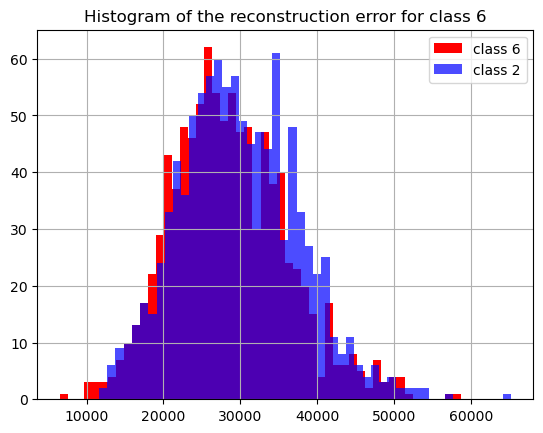

In [38]:
plot_hist_of_recon_error(6)

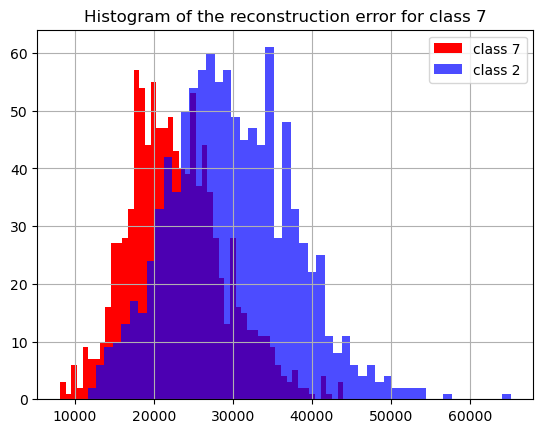

In [39]:
plot_hist_of_recon_error(7)

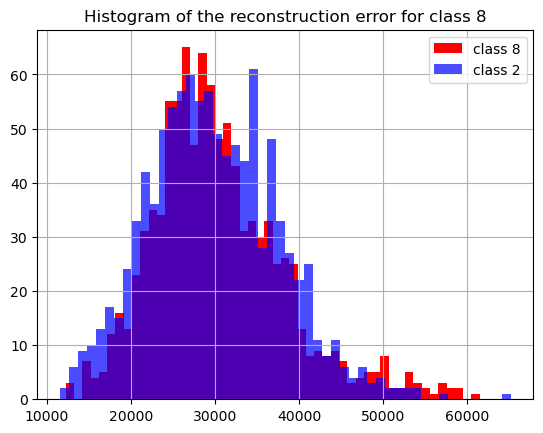

In [40]:
plot_hist_of_recon_error(8)

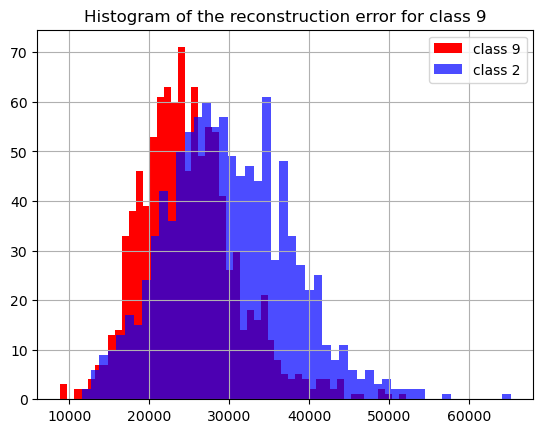

In [41]:
plot_hist_of_recon_error(9)

# Explore model's memory

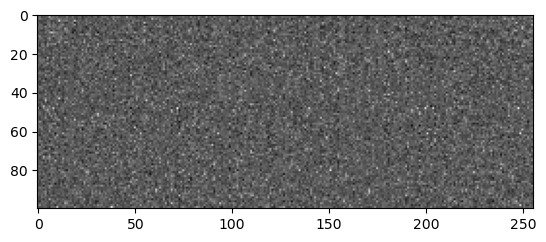

In [43]:
# Plot memory
plt.imshow(model.memory.detach().numpy(), cmap='gray')